## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

# 建立神經網路

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], lreg = l1, l_ratio = 1e-3):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=lreg(l_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=lreg(l_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
regulizer = [l1, l1_l2]

for lreg in regulizer:
    for regulizer_ratio in L_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        lreg_name = 'l1' if lreg == l1 else 'l1_l2'
        print("Experiment with Regulizer = %.6f %s" % (regulizer_ratio, lreg_name))
        model = build_mlp(input_shape=x_train.shape[1:], output_units=10, num_neurons=[512, 256, 128], lreg = lreg, l_ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-%s-%s" % (lreg_name, str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000 l1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 6.0229 - acc: 0.2676 - val_loss: 5.8199 - val_acc: 0.3333
Epoch 2/50
50000/50000 [==============================] - 3s 65us/step - loss: 5.7210 - acc: 0.3627 - val_loss: 5.6400 - val_acc: 0.3855
Epoch 3/50
50000/50000 [==============================] - 3s 66us/step - loss: 5.5712 - acc: 0.3942 - val_loss: 5.5074 - val_acc: 0.4060
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 5.4520 - acc: 0.4154 - val_loss: 5.4011 - val_acc: 0.4186
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 5.3444 - acc: 0.4314 - val_loss: 5.2958 - val_acc: 0.4333
Epoch 6/50
50000/50000 [==============================] - 3s 66us/step - loss: 5.2436 - acc: 0.4459 - val_loss: 5.2089 - val_acc: 0.4338
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 5.1496 - acc: 0.4559 - val_loss: 5.1197 - val_acc

50000/50000 [==============================] - 3s 62us/step - loss: 1.8013 - acc: 0.3718 - val_loss: 1.7564 - val_acc: 0.3928
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7221 - acc: 0.3988 - val_loss: 1.6892 - val_acc: 0.4113
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6657 - acc: 0.4174 - val_loss: 1.6462 - val_acc: 0.4280
Epoch 5/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6192 - acc: 0.4338 - val_loss: 1.6010 - val_acc: 0.4401
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5796 - acc: 0.4482 - val_loss: 1.5717 - val_acc: 0.4506
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5455 - acc: 0.4600 - val_loss: 1.5488 - val_acc: 0.4576
Epoch 8/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5170 - acc: 0.4673 - val_loss: 1.5249 - val_acc: 0.4639
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 61us/step - loss: 1.7368 - acc: 0.3913 - val_loss: 1.7033 - val_acc: 0.4080
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6771 - acc: 0.4104 - val_loss: 1.6488 - val_acc: 0.4203
Epoch 5/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.6296 - acc: 0.4282 - val_loss: 1.6091 - val_acc: 0.4342
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5893 - acc: 0.4427 - val_loss: 1.5962 - val_acc: 0.4393
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.5553 - acc: 0.4559 - val_loss: 1.5634 - val_acc: 0.4426
Epoch 8/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5236 - acc: 0.4662 - val_loss: 1.5341 - val_acc: 0.4573
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4963 - acc: 0.4757 - val_loss: 1.5106 - val_acc: 0.4622
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 3s 65us/step - loss: 2.4632 - acc: 0.0972 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4625 - acc: 0.0983 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4624 - acc: 0.0990 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4624 - acc: 0.0983 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4623 - acc: 0.0968 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4623 - acc: 0.0969 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.4623 - acc: 0.0973 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 3s 65us/step - loss: 10.5387 - acc: 0.4043 - val_loss: 9.8329 - val_acc: 0.4052
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 9.1995 - acc: 0.4113 - val_loss: 8.6021 - val_acc: 0.4146
Epoch 7/50
50000/50000 [==============================] - 3s 65us/step - loss: 8.0600 - acc: 0.4179 - val_loss: 7.5457 - val_acc: 0.4198
Epoch 8/50
50000/50000 [==============================] - 3s 65us/step - loss: 7.0900 - acc: 0.4216 - val_loss: 6.6485 - val_acc: 0.4262
Epoch 9/50
50000/50000 [==============================] - 3s 69us/step - loss: 6.2630 - acc: 0.4262 - val_loss: 5.8980 - val_acc: 0.4174
Epoch 10/50
50000/50000 [==============================] - 3s 68us/step - loss: 5.5584 - acc: 0.4289 - val_loss: 5.2591 - val_acc: 0.4148
Epoch 11/50
50000/50000 [==============================] - 3s 65us/step - loss: 4.9599 - acc: 0.4335 - val_loss: 4.6950 - val_acc: 0.4294
Epoch 12/50
50000/50000 [========================

50000/50000 [==============================] - 3s 65us/step - loss: 7.7153 - acc: 0.4120 - val_loss: 7.2494 - val_acc: 0.4168
Epoch 7/50
50000/50000 [==============================] - 3s 65us/step - loss: 6.8435 - acc: 0.4182 - val_loss: 6.4472 - val_acc: 0.4203
Epoch 8/50
50000/50000 [==============================] - 3s 68us/step - loss: 6.0991 - acc: 0.4233 - val_loss: 5.7637 - val_acc: 0.4240
Epoch 9/50
50000/50000 [==============================] - 3s 65us/step - loss: 5.4624 - acc: 0.4294 - val_loss: 5.1754 - val_acc: 0.4333
Epoch 10/50
50000/50000 [==============================] - 3s 65us/step - loss: 4.9201 - acc: 0.4346 - val_loss: 4.6886 - val_acc: 0.4334
Epoch 11/50
50000/50000 [==============================] - 3s 65us/step - loss: 4.4552 - acc: 0.4389 - val_loss: 4.2548 - val_acc: 0.4363
Epoch 12/50
50000/50000 [==============================] - 3s 66us/step - loss: 4.0574 - acc: 0.4431 - val_loss: 3.8921 - val_acc: 0.4375
Epoch 13/50
50000/50000 [========================

50000/50000 [==============================] - 3s 65us/step - loss: 6.8369 - acc: 0.4186 - val_loss: 6.4464 - val_acc: 0.4154
Epoch 8/50
50000/50000 [==============================] - 3s 69us/step - loss: 6.0922 - acc: 0.4254 - val_loss: 5.7597 - val_acc: 0.4255
Epoch 9/50
50000/50000 [==============================] - 3s 67us/step - loss: 5.4585 - acc: 0.4287 - val_loss: 5.1783 - val_acc: 0.4291
Epoch 10/50
50000/50000 [==============================] - 3s 65us/step - loss: 4.9153 - acc: 0.4345 - val_loss: 4.6775 - val_acc: 0.4354
Epoch 11/50
50000/50000 [==============================] - 3s 67us/step - loss: 4.4514 - acc: 0.4395 - val_loss: 4.2596 - val_acc: 0.4312
Epoch 12/50
50000/50000 [==============================] - 3s 67us/step - loss: 4.0532 - acc: 0.4442 - val_loss: 3.8864 - val_acc: 0.4391
Epoch 13/50
50000/50000 [==============================] - 3s 65us/step - loss: 3.7145 - acc: 0.4474 - val_loss: 3.5676 - val_acc: 0.4462
Epoch 14/50
50000/50000 [=======================

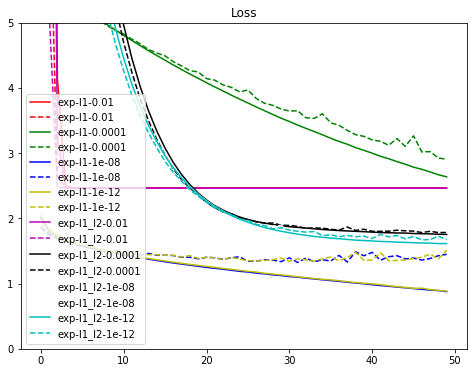

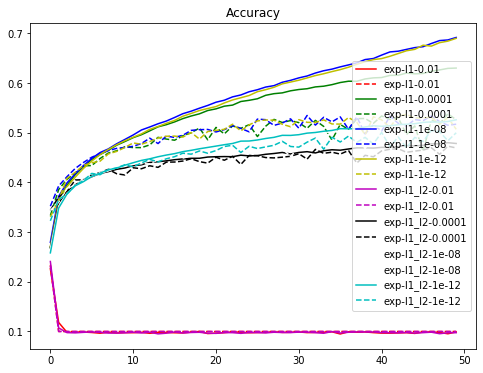

In [8]:
color_bar = ["r", "g", "b", "y", "m", "k", "w", "c"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()